# Naive Market Making Model

## 1. Introduction
This notebook implements a simple (naive) market-making model that serves as a baseline for comparison with more sophisticated strategies like Avellaneda-Stoikov. The model uses fixed spreads and constant order arrival rates without inventory management optimization.

## 2. Model Assumptions
The naive market-making framework relies on the following simplifying assumptions:

* **Mid-price Dynamics**: The underlying asset price follows a Brownian Motion with no drift, meaning price changes are normally distributed and independent of past moves.
* **Constant Spread**: The bid-ask spread is fixed throughout the entire trading session, regardless of market conditions or inventory position.
* **Poisson Order Arrivals**: Market buy and sell orders arrive according to independent Poisson processes with constant arrival rates.
* **No Inventory Management**: The market maker does not adjust quotes based on current inventory position or risk considerations.
* **Symmetric Quotes**: Bid and ask are placed symmetrically around the mid-price at all times.
* **Constant Volatility**: The asset's volatility ($\sigma$) is assumed to be constant throughout the entire trading horizon ($T$).

## 3. Key Parameters
Below are the primary inputs for the model along with their typical ranges and the specific values used in this simulation:

| Parameter | Description | Common Values | Current Value |
| :--- | :--- | :--- | :--- |
| **$\sigma$ (Sigma)** | **Volatility**: Asset price standard deviation. | Asset-dependent | `2.0` |
| **$\delta$ (Delta)** | **Half-Spread**: Fixed distance from mid to bid/ask. | `0.01` to `0.5` | `0.1` |
| **$\lambda_{buy}$** | **Buy Order Rate**: Poisson arrival rate for buys. | `50` to `200` | `100.0` |
| **$\lambda_{sell}$** | **Sell Order Rate**: Poisson arrival rate for sells. | `50` to `200` | `100.0` |
| **$T$** | **Time Horizon**: Normalized trading duration. | `1.0` | `1.0` |

## 4. Dynamics of the Mid-Price
The model assumes the mid-price $s_t$ follows a **Brownian Motion** (random walk without drift):

$$ds_t = \sigma dW_t$$

Where:
* **$\sigma$**: Constant volatility of the asset.
* **$W_t$**: A standard Wiener process.

## 5. Order Arrival Process
Buy and sell market orders arrive according to independent Poisson processes with constant rates:

* **Buy orders**: Arrive at rate $\lambda_{buy}$, hitting the ask price
* **Sell orders**: Arrive at rate $\lambda_{sell}$, hitting the bid price

The probability of an order arriving in a small time interval $dt$ is:

$$P(\text{buy order in } dt) = 1 - e^{-\lambda_{buy} \cdot dt}$$
$$P(\text{sell order in } dt) = 1 - e^{-\lambda_{sell} \cdot dt}$$

## 6. The Quote Placement Strategy
The market maker's quotes are placed symmetrically around the mid-price with a fixed half-spread $\delta$:

$$p^{bid} = s_t - \delta$$
$$p^{ask} = s_t + \delta$$

Where:
* **$s_t$**: Current mid-price
* **$\delta$**: Fixed half-spread (constant parameter)

Unlike sophisticated models, this strategy does not adjust for inventory risk or market conditions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Sample simulation

Performance Metrics:
Sharpe Ratio:  -0.88
Sortino Ratio: -1.23
Max Drawdown:  51.38
Calmar Ratio:  -0.57


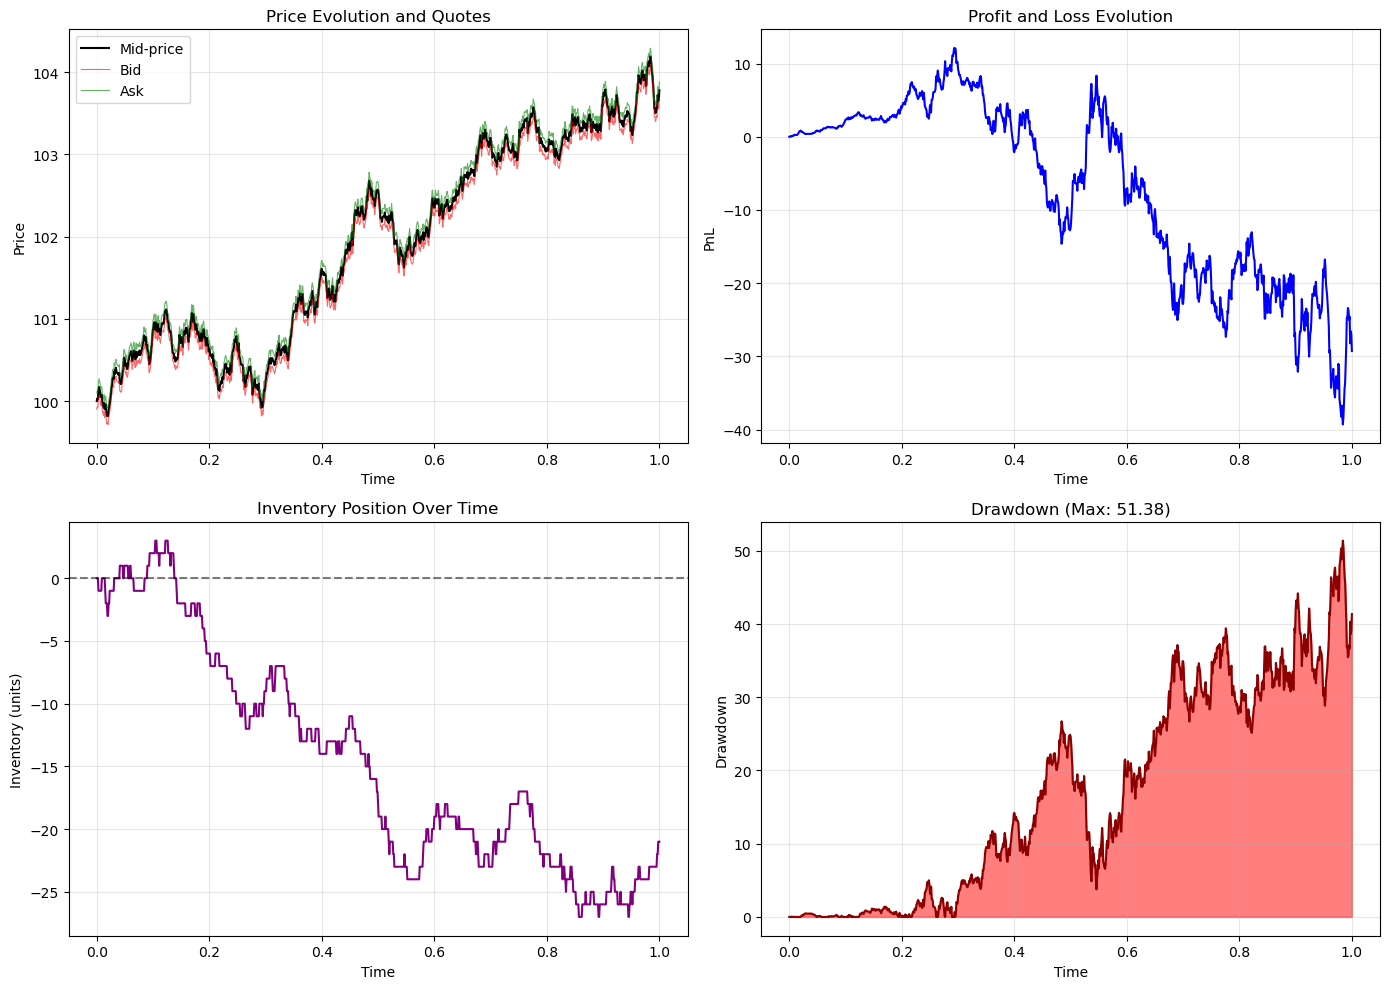

In [2]:
# Model Parameters
sigma = 2.0           # Volatility
delta = 0.1           # Fixed half-spread
lambda_buy = 100.0    # Buy order arrival rate
lambda_sell = 100.0   # Sell order arrival rate
T = 1.0               # Time horizon
n_steps = 1000        # Number of time steps
dt = T / n_steps      # Time step size
s0 = 100.0            # Initial mid-price

# Initialize arrays
s = np.zeros(n_steps + 1)  # Mid-price path
s[0] = s0
q = 0                      # Inventory
cash = 0.0                 # Cash position
pnl = np.zeros(n_steps + 1)  # PnL over time
inventory = np.zeros(n_steps + 1)  # Inventory over time
bid_prices = np.zeros(n_steps + 1)  # Bid quotes
ask_prices = np.zeros(n_steps + 1)  # Ask quotes

# Set initial quotes
bid_prices[0] = s0 - delta
ask_prices[0] = s0 + delta
pnl[0] = 0.0
inventory[0] = 0

# Simulation loop
np.random.seed(42)
for i in range(1, n_steps + 1):
    # Update mid-price (Brownian motion)
    s[i] = s[i-1] + sigma * np.sqrt(dt) * np.random.randn()
    
    # Set quotes symmetrically around mid-price
    bid = s[i] - delta
    ask = s[i] + delta
    bid_prices[i] = bid
    ask_prices[i] = ask
    
    # Check for buy orders (hitting our ask)
    prob_buy = 1 - np.exp(-lambda_buy * dt)
    if np.random.random() < prob_buy:
        q -= 1  # Sell one unit
        cash += ask  # Receive ask price
    
    # Check for sell orders (hitting our bid)
    prob_sell = 1 - np.exp(-lambda_sell * dt)
    if np.random.random() < prob_sell:
        q += 1  # Buy one unit
        cash -= bid  # Pay bid price
    
    # Update PnL and inventory tracking
    pnl[i] = cash + q * s[i]
    inventory[i] = q

# Calculate performance metrics
returns = np.diff(pnl)
mu = np.mean(returns) * n_steps  # Annualized return
vol = np.std(returns) * np.sqrt(n_steps)  # Annualized volatility

sharpe = mu / vol if vol != 0 else 0

downside_returns = returns[returns < 0]
downside_std = np.std(downside_returns) * np.sqrt(n_steps) if len(downside_returns) > 0 else 1e-10
sortino = mu / downside_std if downside_std != 0 else 0

cummax = np.maximum.accumulate(pnl)
drawdown = cummax - pnl
max_dd = np.max(drawdown)
calmar = mu / max_dd if max_dd != 0 else 0

print("Performance Metrics:")
print("====================")
print(f"Sharpe Ratio:  {sharpe:.2f}")
print(f"Sortino Ratio: {sortino:.2f}")
print(f"Max Drawdown:  {max_dd:.2f}")
print(f"Calmar Ratio:  {calmar:.2f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Mid-price evolution with bid/ask
time_grid = np.linspace(0, T, n_steps + 1)
axes[0, 0].plot(time_grid, s, label='Mid-price', linewidth=1.5, color='black')
axes[0, 0].plot(time_grid, bid_prices, label='Bid', linewidth=0.8, alpha=0.6, color='red')
axes[0, 0].plot(time_grid, ask_prices, label='Ask', linewidth=0.8, alpha=0.6, color='green')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Price')
axes[0, 0].set_title('Price Evolution and Quotes')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: PnL evolution
axes[0, 1].plot(time_grid, pnl, linewidth=1.5, color='blue')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('PnL')
axes[0, 1].set_title('Profit and Loss Evolution')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Inventory evolution
axes[1, 0].plot(time_grid, inventory, linewidth=1.5, color='purple')
axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Inventory (units)')
axes[1, 0].set_title('Inventory Position Over Time')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Drawdown
axes[1, 1].fill_between(time_grid, 0, drawdown, alpha=0.5, color='red')
axes[1, 1].plot(time_grid, drawdown, linewidth=1.5, color='darkred')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Drawdown')
axes[1, 1].set_title(f'Drawdown (Max: {max_dd:.2f})')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Monte Carlo Analysis

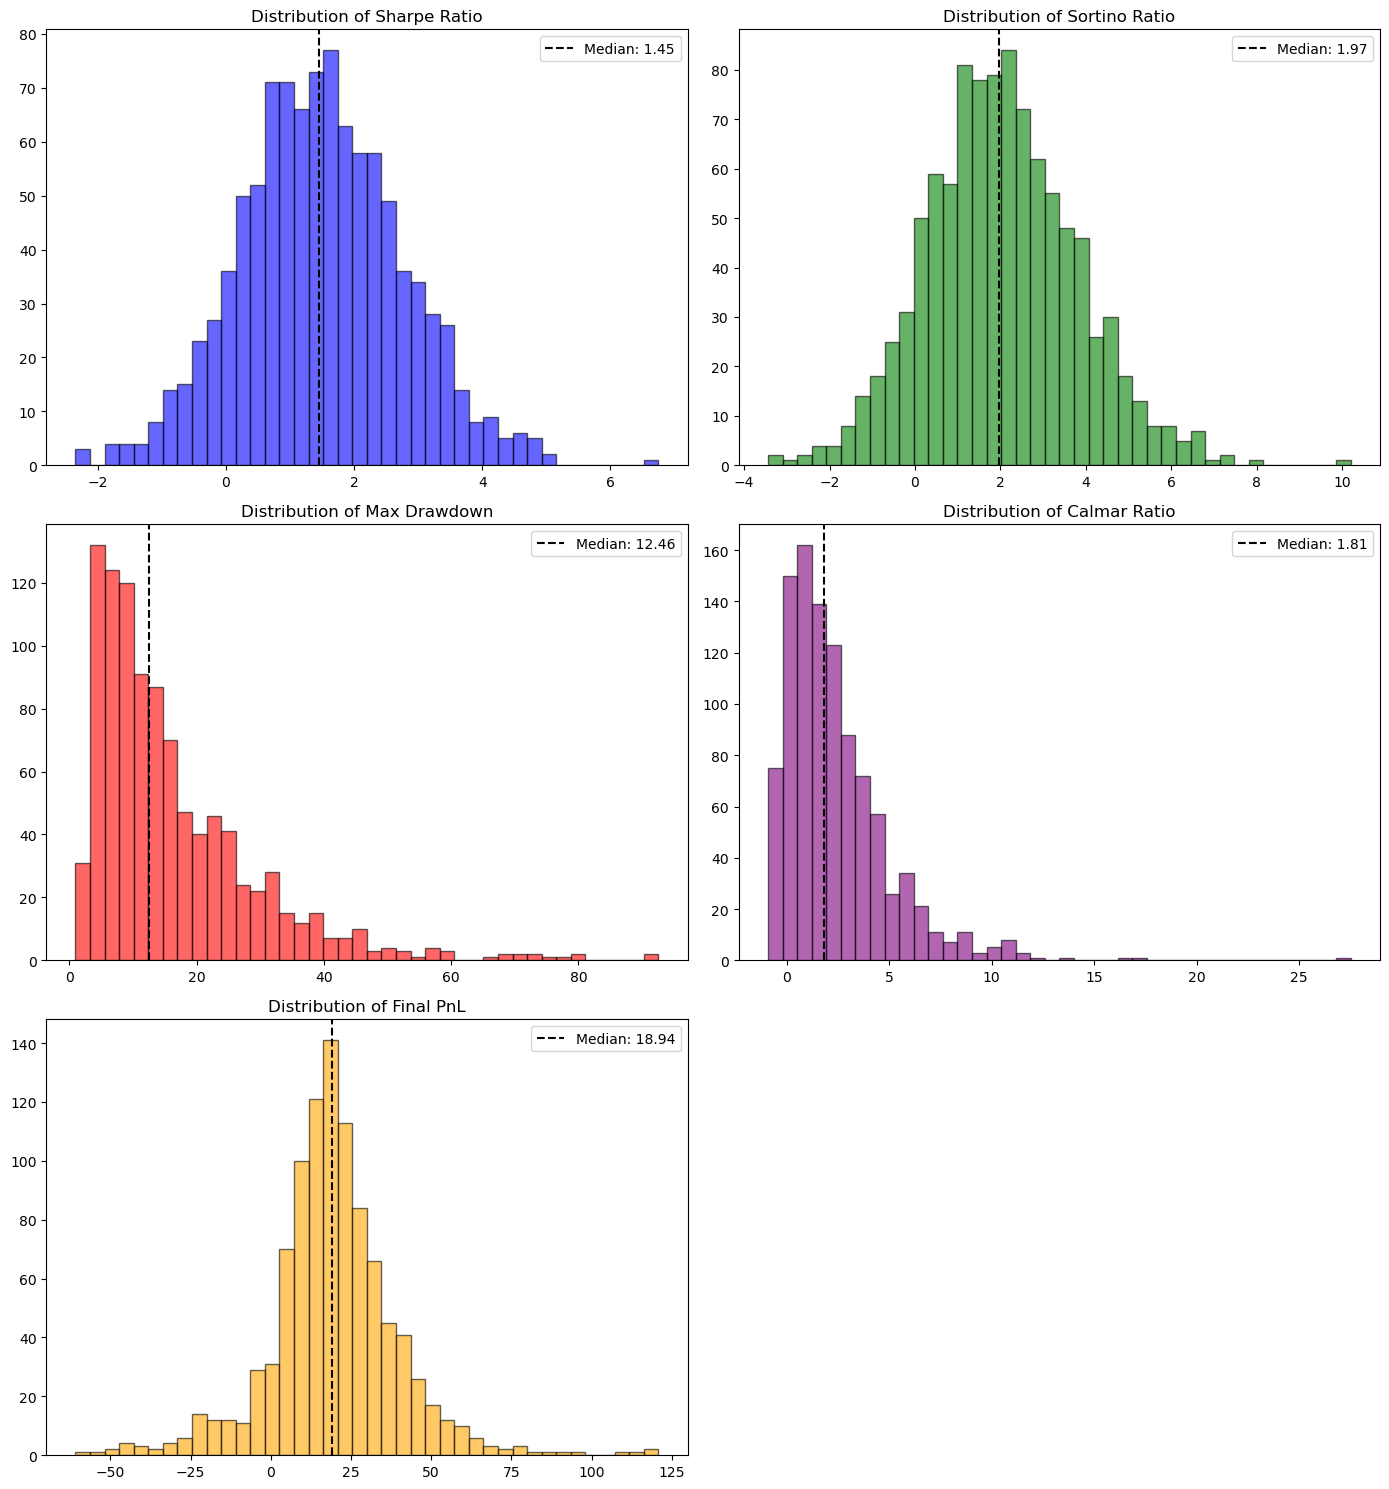

In [3]:
# Monte Carlo Simulation Parameters
N_SIMS = 1000  # Number of simulations

def run_single_simulation():
    """
    Run a single simulation of the naive market-making strategy.
    Returns performance metrics: sharpe, sortino, max_dd, calmar, final_pnl
    """
    # Initialize state
    s = np.zeros(n_steps + 1)
    s[0] = s0
    q = 0
    cash = 0.0
    pnl = np.zeros(n_steps + 1)
    
    # Simulation loop
    for i in range(1, n_steps + 1):
        # Update mid-price (Brownian motion)
        s[i] = s[i-1] + sigma * np.sqrt(dt) * np.random.randn()
        
        # Set quotes symmetrically around mid-price
        bid = s[i] - delta
        ask = s[i] + delta
        
        # Check for buy orders (hitting our ask)
        prob_buy = 1 - np.exp(-lambda_buy * dt)
        if np.random.random() < prob_buy:
            q -= 1
            cash += ask
        
        # Check for sell orders (hitting our bid)
        prob_sell = 1 - np.exp(-lambda_sell * dt)
        if np.random.random() < prob_sell:
            q += 1
            cash -= bid
        
        # Update PnL
        pnl[i] = cash + q * s[i]
    
    # Calculate metrics
    returns = np.diff(pnl)
    mu = np.mean(returns) * n_steps
    vol = np.std(returns) * np.sqrt(n_steps)
    
    sharpe = mu / vol if vol != 0 else 0
    
    downside_returns = returns[returns < 0]
    downside_std = np.std(downside_returns) * np.sqrt(n_steps) if len(downside_returns) > 0 else 1e-10
    sortino = mu / downside_std if downside_std != 0 else 0
    
    max_dd = np.max(np.maximum.accumulate(pnl) - pnl)
    calmar = mu / max_dd if max_dd != 0 else 0
    
    return sharpe, sortino, max_dd, calmar, pnl[-1]

# Execute Monte Carlo
results = np.array([run_single_simulation() for _ in range(N_SIMS)])
sharpes, sortinos, max_dds, calmars, final_pnls = results.T

# Visualization of Distributions
fig, axes = plt.subplots(3, 2, figsize=(14, 15))
metrics = [
    (sharpes, 'Sharpe Ratio', 'blue'),
    (sortinos, 'Sortino Ratio', 'green'),
    (max_dds, 'Max Drawdown', 'red'),
    (calmars, 'Calmar Ratio', 'purple'),
    (final_pnls, 'Final PnL', 'orange')
]

# Plot each metric
for i, (data, title, color) in enumerate(metrics):
    ax = axes.flatten()[i]
    ax.hist(data, bins=40, color=color, alpha=0.6, edgecolor='black')
    ax.axvline(np.median(data), color='black', linestyle='--', label=f'Median: {np.median(data):.2f}')
    ax.set_title(f'Distribution of {title}')
    ax.legend()

# Remove the empty subplot (6th plot)
fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.show()

# References

1. Avellaneda, M., & Stoikov, S. (2008). "High-frequency trading in a limit order book." Quantitative Finance, 8(3), 217-224.

2. Cartea, Á., Jaimungal, S., & Penalva, J. (2015). "Algorithmic and High-Frequency Trading." Cambridge University Press.

3. Lehalle, C. A., & Laruelle, S. (2018). "Market Microstructure in Practice." World Scientific Publishing.

4. Gueant, O. (2016). "The Financial Mathematics of Market Liquidity: From Optimal Execution to Market Making." Chapman and Hall/CRC.